# Data Exploration

The goal here is to look at data from different perspectives and produce some initial insights that could help with story telling.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data
data = pd.read_csv('data/prepared_waste_data.csv')
data.head()

,Unnamed: 0,item,item form,category,shelf life,glass,paper,plastic,aluminium,bio,...,monthly total paper,yearly total paper,monthly total plastic,yearly total plastic,monthly total aluminium,yearly total aluminium,monthly total bio,yearly total bio,monthly total,yearly total
0,0,Milk,Liquid,Food,Short,0,0,33,0,0,...,0.0,0.0,528.0,6864.0,0.0,0.0,0.0,0.0,528.0,6864.0
1,1,Oil Cooking,Liquid,Food,Medium,313,0,0,3,0,...,0.0,0.0,0.0,0.0,14.4,187.2,0.0,0.0,1516.8,19718.4
2,2,Tea Bgs,Solid,Food,Long,0,10,1,0,350,...,10.0,130.0,1.0,13.0,0.0,0.0,350.0,4550.0,361.0,4693.0
3,3,Bread,Solid,Food,Short,0,0,9,0,0,...,0.0,0.0,108.0,1404.0,0.0,0.0,0.0,0.0,108.0,1404.0
4,4,Eggs,Solid,Food,Short,0,29,0,0,42,...,290.0,3770.0,0.0,0.0,0.0,0.0,420.0,5460.0,710.0,9230.0


In [3]:
# Drop the previous index column that was added to CSV
data = data.drop(columns=['Unnamed: 0'])
data.head()

,item,item form,category,shelf life,glass,paper,plastic,aluminium,bio,weekly usage,...,monthly total paper,yearly total paper,monthly total plastic,yearly total plastic,monthly total aluminium,yearly total aluminium,monthly total bio,yearly total bio,monthly total,yearly total
0,Milk,Liquid,Food,Short,0,0,33,0,0,4.00,...,0.0,0.0,528.0,6864.0,0.0,0.0,0.0,0.0,528.0,6864.0
1,Oil Cooking,Liquid,Food,Medium,313,0,0,3,0,1.20,...,0.0,0.0,0.0,0.0,14.4,187.2,0.0,0.0,1516.8,19718.4
2,Tea Bgs,Solid,Food,Long,0,10,1,0,350,0.25,...,10.0,130.0,1.0,13.0,0.0,0.0,350.0,4550.0,361.0,4693.0
3,Bread,Solid,Food,Short,0,0,9,0,0,3.00,...,0.0,0.0,108.0,1404.0,0.0,0.0,0.0,0.0,108.0,1404.0
4,Eggs,Solid,Food,Short,0,29,0,0,42,2.50,...,290.0,3770.0,0.0,0.0,0.0,0.0,420.0,5460.0,710.0,9230.0


In [9]:
# Looking at total yearly waste across all products
data[[i for i in data.columns if i.find("yearly") == 0]].sum()

yearly total glass         62314.20
yearly total paper          7013.76
yearly total plastic       38278.76
yearly total aluminium      2241.20
yearly total bio           78338.00
yearly total              188185.92
dtype: float64

In [11]:
# 188 KG of waste per year on the limited data sample
# if we project this to the population of the world, with the assumption that 50% of the world produces similar
# of more waste per year, and average family size of 3.45 (https://worldpopulationreview.com/country-rankings/family-size-by-country)
# and world population of 8 billion (https://www.worldometers.info/world-population/)

world_population = 8000000000
average_family_size = 3.45
similar_or_more_waste = 0.5
waste_per_month = 188

projected_yearly_waste = waste_per_month * similar_or_more_waste * average_family_size * world_population
print (f'Average yearly waste produced across the world with similar pattern: {projected_yearly_waste}')

Average yearly waste produced across the world with similar pattern: 2594400000000.0


In [12]:
# The data above 2.5 billion tonnes matches the estimates of the world bank (https://datatopics.worldbank.org/what-a-waste/trends_in_solid_waste_management.html)

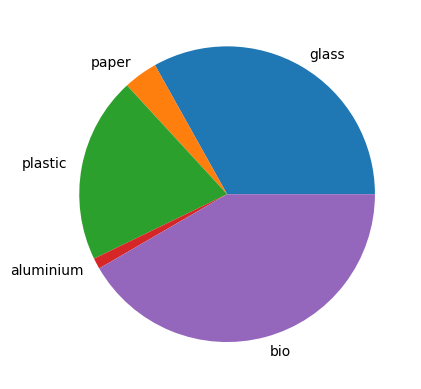

In [18]:
# Exploring the share of each type of waste
col_names = [i for i in data.columns if i.find("yearly total ") == 0]
col_labels = [i.replace("yearly total ", "") for i in col_names]
waste_breakdown = data[col_names].sum()
plt.pie(waste_breakdown, labels=col_labels)
plt.show()

## Exploring categories and their values

In [7]:
# Looking at data points per some categories, to see if we can develop some hypothesis
data.groupby('item form').agg({'item': 'count'})

,item
item form,
Liquid,13
Solid,33


We are going to add new metric based on the recycling information we have:

* Bio waste can be turned fully into BioFuel or compost, so it is not as harmful for the environment
* Glass and Metal can be fully recycled without any limitations, so despite needing energy for it, it won't affect environment that negatively
* Paper can be recycled (if clean, without plastic) but for the limited number of times (6 at max) since the fibers will become shorter after every recycle and eventually will turn into toilet paper and leave the recycling loop. So despite the ability to recycle, it has bad environmental impact since the production and recycling both affects the environment
* Plastic has very limited recycling possibility due to the fact that it is cost and very energy intensive and cost of it is higher than producing new plastic, so unless there is a very good demand for the recycled plastic, it might not be cost efficient to recycle, and they often ended up with other waste in landfills

In [4]:
def enviromental_impact_metric(row):
    # returns a number between 0 and 1
    # 1 or close to 1 means it is very harmful, which means it has higher plastic and paper waste
    # 0 or close to 0 means it is not that harmful, since it generates BIO of fully recycleable waste
    total_waste = row['glass'] + row['paper'] + row['plastic'] + row['aluminium'] + row['bio']
    not_harmful_waste = row['glass'] + row['aluminium'] + row['bio']
    return 1 - not_harmful_waste / total_waste

data['env impact'] = data.apply(enviromental_impact_metric, axis=1)

In [14]:
data[['item', 'env impact']].head(10)

,item,env impact
0,Milk,1.000000
1,Oil Cooking,0.000000
2,Tea Bgs,0.030471
3,Bread,1.000000
4,Eggs,0.408451
5,Cooking Butter,1.000000
6,Cooking Cream,1.000000
7,Pasta,1.000000
8,Parmesan Chheese,1.000000
9,Cheese,1.000000


In [24]:
# Looking at shelf life and how other parameters look like in it
data.groupby('shelf life').agg({'item': 'count', 'weekly usage': 'mean', 'weekly total': 'mean', 'env impact': 'mean'})

,item,weekly usage,weekly total,env impact
shelf life,,,,
Long,20,0.533000,93.250000,0.689406
Medium,12,1.983333,82.916667,0.673702
Short,14,1.910714,57.428571,0.589650


Going to plot some graphs to check if we can see clear correlation between some columns

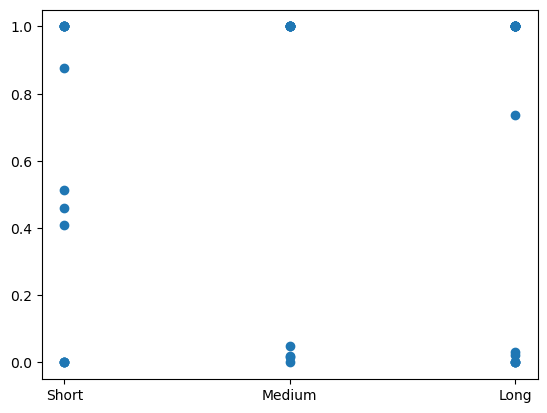

In [20]:
plt.scatter(data['shelf life'],data['env impact'])
plt.show()

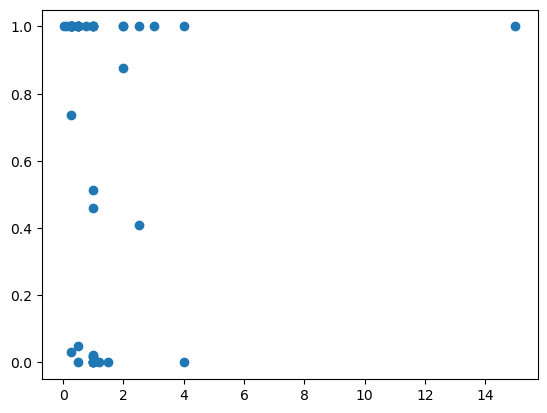

In [21]:
# Weekly usage relationship with env impact
plt.scatter(data['weekly usage'],data['env impact'])
plt.show()

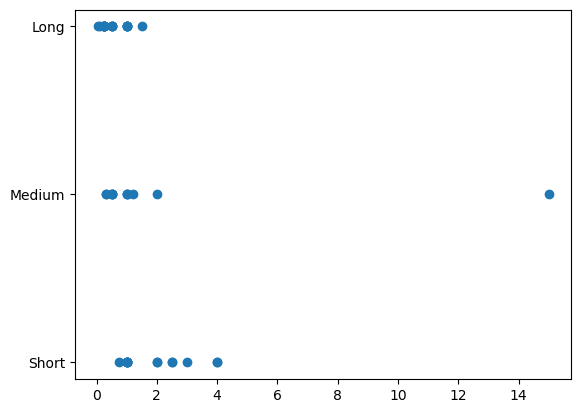

In [29]:
plt.scatter(data['weekly usage'],data['shelf life'])
plt.show()

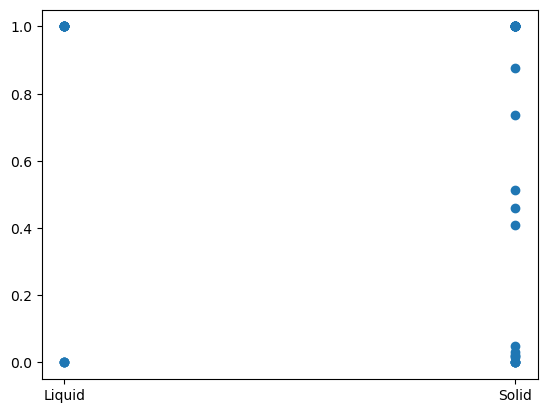

In [22]:
# It seems liquids are either using plastic or glass/aluminium, but no in between
# But solid forms they have more mixture of packaging
plt.scatter(data['item form'],data['env impact'])
plt.show()

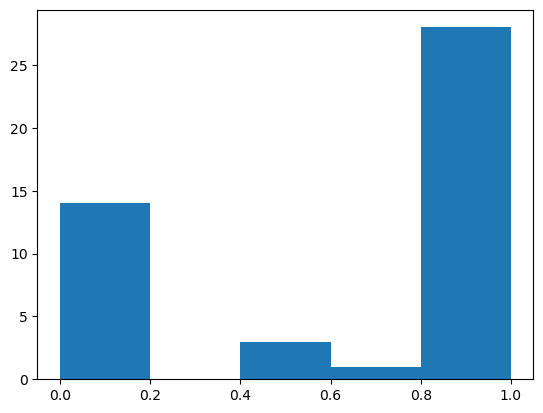

In [26]:
# It seems the env impact in the data sample is mostly in the two extremes
plt.hist(data['env impact'], bins=5)
plt.show()

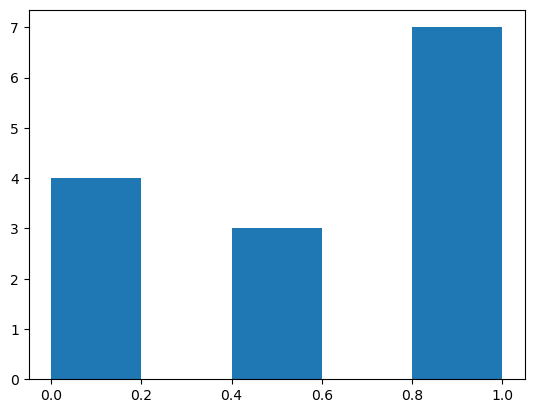

In [27]:
plt.hist(data[data['shelf life'] == 'Short']['env impact'], bins=5)
plt.show()

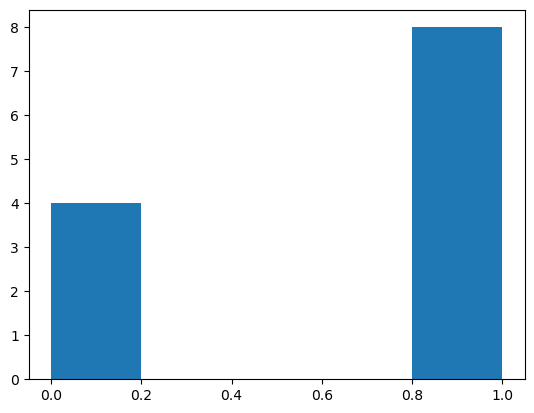

In [28]:
plt.hist(data[data['shelf life'] == 'Medium']['env impact'], bins=5)
plt.show()

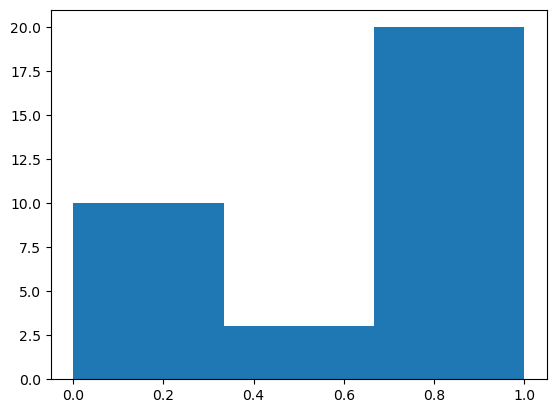

In [32]:
plt.hist(data[data['item form'] == 'Solid']['env impact'], bins=3)
plt.show()

## Hypothesis 

Items with short shelf time tends to have worst environmental impact, which means the `env impact` is greater than `0.5` with 95% certainity (more than half of the waste produced are harmful for the environment).

Null Hypothesis: env impact <= 0.5

Alternative Hypothesis: env impact > 0.5

In [5]:
import numpy as np
from scipy.stats import ttest_1samp

In [8]:
dataset = data[data['shelf life'] == 'Short']['env impact']
dataset.shape

(14,)

In [12]:
test_result = ttest_1samp(dataset, 0.5, alternative='greater')
test_result

TtestResult(statistic=0.7591336371118553, pvalue=0.23065818597226034, df=13)

## Save Data

Now that we modified our data, we are going to save it so we could visualise it in Tableau.

In [5]:
data.to_csv('data/waste-data-final.csv')